In [1]:
"""
This notebook will allow you to train or run a model on an individual modality
"""

import torch
import numpy as np
import torch.optim as optim
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from Models.Base_3DCAE import Base_3DCAE
from io import StringIO
import os
import ffmpeg
import pdb
import parameters
from dataset_loader import create_pytorch_dataset
from functions import get_total_performance_metrics
from functions import get_performance_metrics
from functions import get_global_performance_metrics
from functions import get_window_metrics
from functions import get_frame_metrics
from functions import animate

Train Dataloader - 48
Test Dataloader - 173

Device Used - cuda

Model Used - Base_3DCAE
Feature Extraction - True
Background Subtraction - True
Background Subtraction Algorithm - GMG
Data Augmentation - False

Window Length = 8
Stride = 1
Fair Comparison = True
Dropout = 0.25
Learning Rate = 0.0002
Num Epochs = 20
Chunk Size = 64
Forward Chunk = 8
Forward Chunk Size = 8
Loss Fn = L1Loss()

Training has Begun
epoch [1/20], loss:0.2169
epoch [2/20], loss:0.2165
epoch [3/20], loss:0.2164
epoch [4/20], loss:0.2165
epoch [5/20], loss:0.2164
epoch [6/20], loss:0.2163
epoch [7/20], loss:0.2163
epoch [8/20], loss:0.2162
epoch [9/20], loss:0.2162
epoch [10/20], loss:0.2161
epoch [11/20], loss:0.2161
epoch [12/20], loss:0.2160
epoch [13/20], loss:0.2160
epoch [14/20], loss:0.2160
epoch [15/20], loss:0.2159
epoch [16/20], loss:0.2158
epoch [17/20], loss:0.2159
epoch [18/20], loss:0.2159
epoch [19/20], loss:0.2158


c:\Users\abdul\anaconda3\envs\fyp_base_paper_2\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


epoch [20/20], loss:0.2158
Training has Completed

Forward pass occuring
Forward pass completed

Thermal_T3_2024-03-14-05-42-54

----------------------------------
STD Global Classification Results
TPR 0.765, FPR 0.172, Precision 0.067, Recall 0.765
tn 54989, fp 11400, fn 252, tp 820
std_AUROC  0.839
----------------------------------
----------------------------------
Mean Global Classification Results
TPR 0.750, FPR 0.157, Precision 0.071, Recall 0.750
tn 55944, fp 10445, fn 268, tp 804
mean_AUROC 0.829
----------------------------------


d:\Abdul Rasheed NITT\Academics\Eigth Semester\FYP\Implementation\FallDetection\Code\functions.py:250: RuntimeWarning: Mean of empty slice
  final_performance_mean = np.nanmean(video_metrics, axis=0)  # get the mean performance across all videos
c:\Users\abdul\anaconda3\envs\fyp_base_paper_2\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


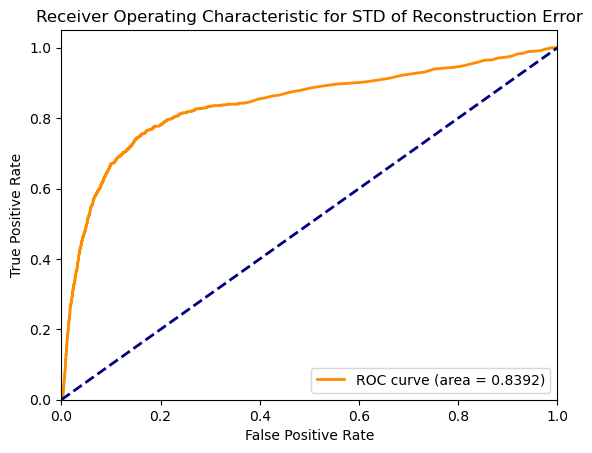

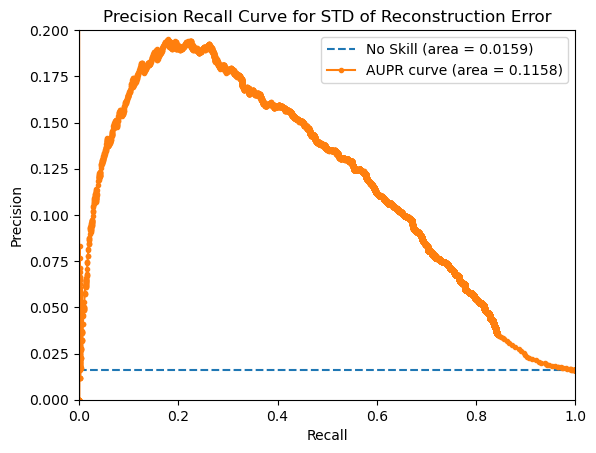

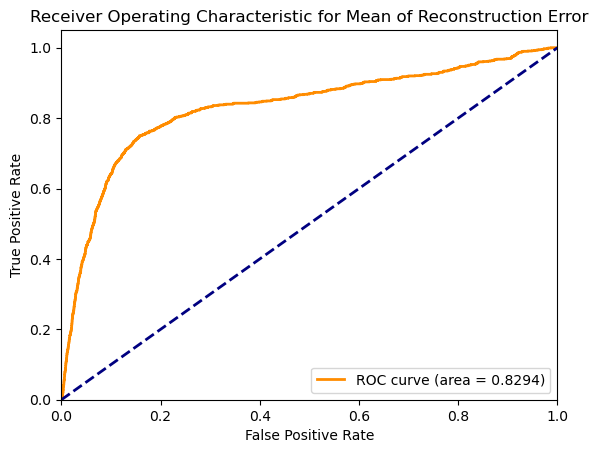

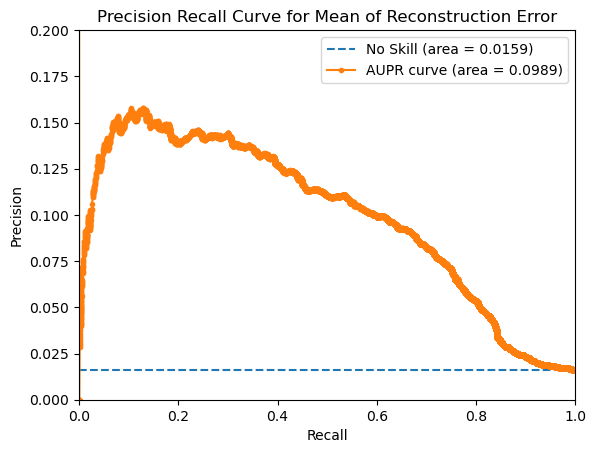

In [2]:
# Parameters

window_len = parameters.window_len
stride = parameters.stride
fair_comparison = parameters.fair_comparison

device = parameters.device

dropout = parameters.dropout
learning_rate = parameters.learning_rate
num_epochs = parameters.num_epochs
chunk_size = parameters.chunk_size
forward_chunk = parameters.forward_chunk
forward_chunk_size = parameters.forward_chunk_size
loss_fn = parameters.loss_fn
TOD = parameters.TOD

project_directory = parameters.project_directory


def full_pipeline(name, dset, window_len, fair_comparison, path, stride, modelpath):

    # Lets load the H5PY dataset into a pytorch dataset class.Please see dataset_creator on how to generate the H5PY file.
    Test_Dataset, test_dataloader, Train_Dataset, train_dataloader = create_pytorch_dataset(
        name, dset, path, window_len, fair_comparison, stride, TOD
    )
    print("Train Dataloader - {}".format(len(train_dataloader)))
    print("Test Dataloader - {}\n".format(len(test_dataloader)))

    # Prepare for GPU training
    print("Device Used - " + device)
    torch.cuda.empty_cache()

    # Select which model to use
    model = Base_3DCAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Printing methodology
    # Printing the class name of the model being used
    print("\nModel Used - " + model.__class__.__name__)
    print("Feature Extraction - {}".format(parameters.feature_extraction))
    if parameters.feature_extraction:
        print("Background Subtraction - {}".format(parameters.background_subtraction))
        if parameters.background_subtraction:
            print("Background Subtraction Algorithm - {}".format(parameters.background_subtraction_algorithm))
    print("Data Augmentation - {}\n".format(parameters.data_augmentation))

    # Printing Parameters
    print(
        "Window Length = {}\nStride = {}\nFair Comparison = {}\nDropout = {}\nLearning Rate = {}\nNum Epochs = {}\nChunk Size = {}\nForward Chunk = {}\nForward Chunk Size = {}\nLoss Fn = {}\n".format(
            window_len,
            stride,
            fair_comparison,
            dropout,
            learning_rate,
            num_epochs,
            chunk_size,
            forward_chunk,
            forward_chunk_size,
            loss_fn,
        )
    )

    # Training our model
    def train_model(filepath):
        print("Training has Begun")
        model.train()  # Sets the model in training mode.

        for epoch in range(num_epochs):
            val_loss = 0  # Not used
            frame_stats = []  # Frame level statistics
            window_stats = []  # Window level statistics

            for i, (sample, labels) in enumerate(train_dataloader):
                sample = sample.to(device, dtype=torch.float)  # Moves the input sample tensor to the specified device
                chunks = torch.split(sample, chunk_size, dim=1)  # Splits the input sample into smaller chunks
                recon_vid = []  # Empty list to store reconstructed video chunks

                for chunk in chunks:
                    # ===================forward=====================
                    output = model(chunk)  # Perform a forward pass of the model on the current chunk
                    output = output.to(device).permute(1, 0, 2, 3, 4)  # Moves the output tensor to the device and permutes its dimensions. # fmt: skip
                    model.zero_grad()  # Clears the gradients of the model parameters.
                    loss = loss_fn(output, chunk)  # Computes the loss between the reconstructed output and the original chunk of data. # fmt: skip
                    recon_vid.append(output)  # Appends the reconstructed output

                    # ===================backward====================
                    loss.backward()  # Getting gradients of the loss w.r.t. model parameters
                    optimizer.step()  # Updating model parameters
                    optimizer.zero_grad()  # Clear gradients of the model parameters for next iteration
                    torch.cuda.empty_cache()

                if epoch == num_epochs - 1:
                    output = torch.cat(recon_vid, dim=1)  # Concatenate reconstructed chunks
                    # convert tensors to numpy arrays for easy manipluations
                    sample = sample.data.cpu().numpy()
                    output = output.data.cpu().numpy()
                    labels = labels.data.cpu().numpy()
                    frame_std, frame_mean, frame_labels, window_std, window_mean, window_labels = (
                        get_performance_metrics(sample, output, labels, window_len)
                    )
                    frame_stats.append([frame_mean, frame_std, frame_labels])
                    window_stats.append([window_mean, window_std, window_labels])

            if epoch == num_epochs - 1:
                # get_total_performance_metrics(frame_stats, window_stats, window_len)
                recon_errors = []
                recon_labels = []
                for i in range(len(frame_stats)):
                    # this is single video metrics
                    frame_mean, frame_std, frame_labels = frame_stats[i]
                    recon_errors.append([frame_mean, frame_std])
                    recon_labels.append(frame_labels)
                np.save(
                    project_directory + "\Output\Recon_Errors\\train_recon_errors_{}.npy".format(modality),
                    recon_errors,
                )
                np.save(
                    project_directory + "\Output\Recon_Errors\\train_recon_labels_{}.npy".format(modality),
                    recon_labels,
                )

            # ===================log========================
            print("epoch [{}/{}], loss:{:.4f}".format(epoch + 1, num_epochs, loss.item()))
            torch.save(model.state_dict(), filepath)  # save the model each epoch at location filepath

        torch.cuda.empty_cache()
        print("Training has Completed\n")

    # Forward pass of model on test dataset
    def forward_pass(path):
        model.load_state_dict(torch.load(path))  # Load saved model weights
        model.eval()  # Sets the model in testing mode.

        frame_stats = []
        window_stats = []

        with torch.no_grad():  # Disable gradient computation for efficiency
            print("Forward pass occuring")
            for j, (sample, labels) in enumerate(test_dataloader):
                # forward pass to get output
                torch.cuda.empty_cache()
                sample = sample.to(device, dtype=torch.float)
                chunks = torch.split(sample, forward_chunk, dim=1)
                recon_vid = []
                for chunk in chunks:
                    output = model(chunk)
                    output = output.to(device).permute(1, 0, 2, 3, 4)
                    recon_vid.append(output)
                    torch.cuda.empty_cache()
                output = torch.cat(recon_vid, dim=1)
                # convert tensors to numpy arrays for easy manipluations
                sample = sample.data.cpu().numpy()
                output = output.data.cpu().numpy()
                labels = labels.data.cpu().numpy()

                frame_std, frame_mean, frame_labels, window_std, window_mean, window_labels = get_performance_metrics(
                    sample, output, labels, window_len
                )
                frame_stats.append([frame_mean, frame_std, frame_labels])
                window_stats.append([window_mean, window_std, window_labels])

                # if j % 10 == 0:
                # print(sample.shape)
                # animate(sample[0, :, :, :, :], output[0, :, :, :, :], frame_mean, dset, start_time)

            print("Forward pass completed\n")

        return (frame_stats, window_stats)

    start_time = str(datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S"))
    modality = name + "_" + start_time
    filepath = project_directory + "\Output\Models\\" + modality

    # Comment out this call if you dont want to train a model
    train_model(filepath)

    # Insert any modelpath instead of filepath to use a specified pre trained model
    frame_stats, window_stats = forward_pass(filepath)

    print("{}\n".format(modality))
    get_total_performance_metrics(modality, frame_stats, window_stats, window_len)
    get_global_performance_metrics(modality, frame_stats, window_stats, window_len)

    return ()


# Directory names of the raw dataset from the Fall-Data folder
# list_of_files = ['Thermal','ONI_IR','IP']
list_of_files = ["Thermal"]

# Dataset names used during H5PY file creation (dsets variable from dataset_creator.py)
# list_of_datasets = ['Thermal_T3','ONI_IR_T','IP_T']
list_of_datasets = ["Thermal_T3"]

# List of pre-trained model weight location if wanting to test pre-trained model. 'x' should be replaced with path to model weight location
# list_of_models = ['x','x','x','x','x','x']
list_of_models = ["x"]

for i in range(len(list_of_datasets)):
    modelpath = list_of_models[i]
    name = list_of_datasets[i]
    dset = list_of_files[i]
    path = "{}\Dataset\H5PY\Data_set-{}-imgdim64x64.h5".format(project_directory, name)
    full_pipeline(name, dset, window_len, fair_comparison, path, stride, modelpath)